Some of my emu optimizations have poor performance, and I want to make some plots to see if there is a bug I should be fixing. 

In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import matplotlib
#matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [18]:
from pearce.emulator import LemonPepperWet
from itertools import product
from GPy.kern import *
import numpy as np
from os import path
from sys import argv
import h5py

In [19]:
training_file = '/u/ki/swmclau2/des/ds_zheng07/PearceDsCosmo.hdf5'
assert path.isfile(training_file)
test_file = '/u/ki/swmclau2/des/ds_zheng07_test/PearceDsCosmoTest.hdf5'
assert path.isfile(test_file)

In [20]:
with h5py.File(training_file, 'r') as f:
    HOD_params = len(f.attrs['hod_param_names'])

In [21]:
fixed_params = {'z':0.0}#, 'r':0.11972916}

In [22]:
cosmo_idx, hod_idx = 2,0
cosmo_kernels = [Linear(input_dim=7, ARD=True), RBF(input_dim=7, ARD=True), Linear(input_dim=7, ARD=True) + RBF(input_dim=7, ARD=True), Linear(input_dim=7, ARD=True) + Matern32(input_dim=7, ARD=True), \
          Matern32(input_dim=7, ARD=True)+RBF(input_dim=7, ARD=True) + Bias(input_dim=7)]
HOD_kernels = [ Matern32(input_dim=HOD_params, ARD=True), RBF(input_dim=HOD_params, ARD=True) + Linear(input_dim=HOD_params, ARD=True), Matern32(input_dim=HOD_params, ARD=True)+RBF(input_dim=HOD_params, ARD=True) + Bias(input_dim=HOD_params)\
               , RBF(input_dim=HOD_params, ARD=True) +Bias(input_dim=HOD_params)]

#k = (cosmo_kernels[3], HOD_kernels[0])
k = (cosmo_kernels[cosmo_idx], HOD_kernels[hod_idx], RBF(input_dim=1, ARD=True)+ Bias(input_dim=1))

In [23]:
hyperparams = hyperparams = {'kernel': k , \
               'optimize': True}

In [24]:
emu = LemonPepperWet(training_file,# hyperparams=hyperparams,
                     fixed_params = fixed_params, downsample_factor = 1.0)

(40, 7) (1000, 5) (18, 1)


 /u/ki/swmclau2/.local/lib/python2.7/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


In [25]:
emu.save_as_default_kernel()

 /u/ki/swmclau2/.local/lib/python2.7/site-packages/pearce/emulator/emu.py:2944: H5pyDeprecationWarning:The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.


In [26]:
emu.y.shape

(40, 1000, 18)

In [27]:
print emu._emulator.X0.shape
print emu._emulator.X1.shape
print emu._emulator.X2.shape

(40, 7)
(1000, 5)
(18, 1)


In [28]:
pred_y, data_y = emu.goodness_of_fit(test_file, statistic = None)

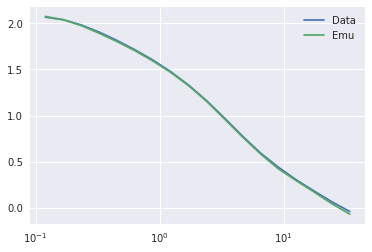

In [29]:
idx = np.random.randint(0, 3500)
plt.plot(emu.scale_bin_centers, data_y[:,idx], label = 'Data')
plt.plot(emu.scale_bin_centers, pred_y[:,idx], label = 'Emu')
plt.legend(loc='best')
plt.xscale('log')

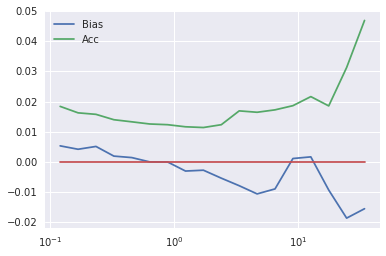

In [30]:
plt.plot(emu.scale_bin_centers, ((10**pred_y - 10**data_y)/(10**data_y)).mean(axis=1), label= 'Bias')
plt.plot(emu.scale_bin_centers, (np.abs(10**pred_y - 10**data_y)/(10**data_y)).mean(axis =1), label = 'Acc')
plt.plot(emu.scale_bin_centers, np.zeros_like(emu.scale_bin_centers))
plt.xscale('log')
plt.legend(loc='best')
#plt.ylim([-0.05, 0.2])
plt.show()
# average over realizations

In [58]:
pred_y_rs= pred_y.reshape((len(emu.scale_bin_centers),5,7, -1), order = 'F')[:,0,:,:]
data_y_rs= data_y.reshape((len(emu.scale_bin_centers),5,7, -1), order = 'F').mean(axis = 1)
R = (10**pred_y_rs - 10**data_y_rs).reshape((18,-1), order = 'F')

In [59]:
cov = R.dot(R.T)/(R.shape[1]-1)
print 'Yerr', np.sqrt(np.diag(cov))/(10**data_y.mean(axis=1))
print '*'*10

#np.save(save_fname, cov)

Yerr [0.07752582 0.06974877 0.05760022 0.04221729 0.03891663 0.06392238
 0.09873114 0.14250404 0.18864993 0.22922431 0.25347687 0.25117421
 0.22711211 0.19516557 0.16768022 0.14122506 0.1265593  0.1224677 ]
**********


In [60]:
from pearce.mocks import cat_dict
np.random.seed(0)
boxno = np.random.randint(0,7)
hod_idx = np.random.randint(0,100)

realization = 0
cat = cat_dict['testbox'](boxno = boxno, realization = realization )#construct the specified catalog!

In [61]:
print hod_idx, boxno

47 4


In [62]:
with h5py.File(test_file, 'r') as f:
    hod_param_names = f.attrs['hod_param_names']
    hod_param_vals = f.attrs['hod_param_vals'][hod_idx]
    
    cosmo_param_names = f.attrs['cosmo_param_names']
    cosmo_param_vals = f.attrs['cosmo_param_vals'][boxno*5+realization]
    
    true_data = f['cosmo_no_%02d'%(boxno*5+realization)]['a_1.000']['obs'][hod_idx]

hod_params = dict(zip(hod_param_names, hod_param_vals))

#hod_params.update(dict(zip(cosmo_param_names, cosmo_param_vals)))

In [63]:
cpv = cat._get_cosmo_param_names_vals()

cat_val_dict =  {key: val for key, val in zip(cpv[0], cpv[1])}

In [64]:
true_param_dict = cat_val_dict.copy()
for hp, hv in hod_params.iteritems():
    if hp == 'logMmin':
        continue
    true_param_dict[hp] = hv
true_pred = emu.emulate_wrt_r(true_param_dict)[0]

In [65]:
rbc = emu.scale_bin_centers

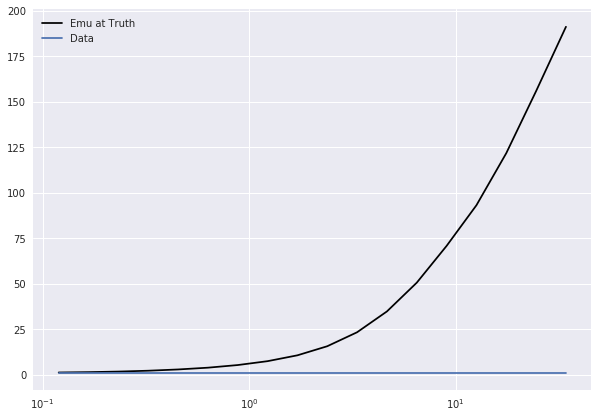

In [66]:
fig = plt.figure(figsize=(10,7))

plt.plot(rbc, 10**true_pred/10**true_data,label = 'Emu at Truth', color ='k')
#plt.plot(rbc, 10**pop_xi.mean(axis = 0), label = 'Sim' )
#plt.errorbar(rbc, np.ones_like(true_data), yerr=yerr/true_data, label = 'Data')
plt.plot(rbc, np.ones_like(true_data), label = 'Data')

plt.xscale('log')
plt.legend(loc='best')
plt.show();

In [67]:
emu.get_param_names()

['ombh2',
 'omch2',
 'w0',
 'ns',
 'ln10As',
 'H0',
 'Neff',
 'logM1',
 'logM0',
 'sigma_logM',
 'alpha',
 'conc_gal_bias']

In [68]:
N = 100
cmap = sns.color_palette("BrBG_d", N)

In [69]:
fig = plt.figure(figsize=(10,7))
varied_pname = 'mean_occupation_centrals_assembias_param1'
lower, upper = emu.get_param_bounds(varied_pname)
i = 0
for c, val in zip(cmap, np.linspace(lower, upper, N) ):
    #print i, val
    #i+=1
    param_dict = true_param_dict.copy()
    param_dict[varied_pname] = val
    pred = emu.emulate_wrt_r(param_dict)[0]
    plt.plot(rbc, (10**pred-10**true_data[-len(emu.scale_bin_centers):])/10**true_data[-len(emu.scale_bin_centers):],\
             alpha = 0.5,label = val, color =c)
    
pred = emu.emulate_wrt_r(true_param_dict)[0]
plt.plot(rbc, (10**pred-10**true_data[-len(emu.scale_bin_centers):])/10**true_data[-len(emu.scale_bin_centers):], label = 'Truth', color = 'k')    
#plt.errorbar(rbc, np.zeros_like(true_data[-len(emu.scale_bin_centers):]), yerr=yerr/true_data[-len(emu.scale_bin_centers):], label = 'Data')
#plt.loglog()
plt.xscale('log')
#plt.legend(loc='best')
plt.show();

KeyError: 'Parameter mean_occupation_centrals_assembias_param1 could not be found.'

In [ ]:
train_y = (emu.y.T*emu._y_std + emu._y_mean).T

In [ ]:
test_y = data_y.reshape((18, 35, 100))

In [ ]:
plt.plot(emu.scale_bin_centers, emu._y_mean)
plt.plot(emu.scale_bin_centers, test_y.mean(axis = (1,2)))
plt.xscale('log')